In [1]:
# from sim_bfr_240611.config import RAW_DATA_DIR
RAW_DATA_DIR = 'Greg_simulation'
import scipp as sc
import plopp as pp
import scippneutron as scn
import scippnexus as snx
import numpy as np
from easyscience.Objects.new_variable import Parameter
from easyscience.Objects.ObjectClasses import BaseObj
from easyscience.fitting import Fitter
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d


In [2]:
def find_fwhm(data, x=None, fraction=0.5):
    """
    Find the full width at a specified fraction of the maximum of a peak in the data.
    The function returns the crossing points that are closest to the peak maximum.

    Parameters:
    - data (numpy array): The data containing the peak.
    - x (numpy array): The x-axis values corresponding to the data points. If None, indices will be used.
    - fraction (float): The fraction of the maximum to find the width at. Default is 0.5 (FWHM).

    Returns:
    - width (float): The full width at the specified fraction of the maximum.
    - left_crossing, right_crossing (float): The x-values of the crossing points.
    """

    if x is None:
        x = np.arange(len(data))  # Use indices if x is not provided

    # Ensure x is a numpy array
    x = np.asarray(x)

    # Find the maximum value and its index
    max_value = np.max(data)
    max_index = np.argmax(data)

    # Find the value corresponding to the specified fraction of the maximum
    target_value = max_value * fraction

    # Find the indices where the data crosses the target value
    indices = np.where(data >= target_value)[0]

    if len(indices) < 2:
        return None, None, None  # The peak doesn't cross the target value twice

    # Filter to find the closest points to the peak maximum
    left_indices = indices[indices < max_index]
    right_indices = indices[indices > max_index]

    if len(left_indices) == 0 or len(right_indices) == 0:
        return None, None, None  # No valid crossing points found

    left_index = left_indices[-1]
    right_index = right_indices[0]

    # Interpolation for more precise crossing points
    if left_index > 0:
        interp_left = interp1d(data[left_index-1:left_index+1], x[left_index-1:left_index+1], bounds_error=False, fill_value="extrapolate")
        left_crossing = interp_left(target_value)
    else:
        left_crossing = x[left_index]

    if right_index < len(data) - 1:
        interp_right = interp1d(data[right_index:right_index+2], x[right_index:right_index+2], bounds_error=False, fill_value="extrapolate")
        right_crossing = interp_right(target_value)
    else:
        right_crossing = x[right_index]

    # Ensure that the crossings are within the bounds of x
    left_crossing = max(left_crossing, x[0])
    right_crossing = min(right_crossing, x[-1])

    # Calculate the full width at the specified fraction
    width = right_crossing - left_crossing

    return width, left_crossing, right_crossing



In [3]:
def find_threshold_crossing(data, x=None, threshold_fraction=0.5):
    """
    Find the x-values where the data crosses a specified threshold of the peak value,
    considering the cyclic nature of the data.

    Parameters:
    - data (numpy array): The data containing the peak.
    - x (numpy array): The x-axis values corresponding to the data points. If None, indices will be used.
    - threshold_fraction (float): The fraction of the peak value to find the crossing at.

    Returns:
    - left_x (float): The x-value of the crossing point to the left of the peak.
    - right_x (float): The x-value of the crossing point to the right of the peak.
    - peak_x (float): The x-value of the peak.
    - width (float): The calculated width of the peak considering the cyclic nature.
    """

    if x is None:
        x = np.arange(len(data))  # Use indices if x is not provided

    # Ensure x is a numpy array
    x = np.asarray(x)

    # Find the maximum value and its index
    max_value = np.max(data)
    max_index = np.argmax(data)
    peak_x = x[max_index]

    # Calculate the threshold value
    threshold_value = max_value * threshold_fraction

    # Find left crossing
    left_x = None
    for i in range(max_index, max_index - len(data), -1):
        idx = i % len(data)  # Wrap around using modulo
        if data[idx] < threshold_value:
            if idx == 0:
                interp_left = np.interp(threshold_value, [data[-1], data[0]], [x[-1] - x[-1] + x[0], x[0]])
            else:
                interp_left = np.interp(threshold_value, [data[idx-1], data[idx]], [x[idx-1], x[idx]])
            left_x = interp_left
            break

    # Find right crossing
    right_x = None
    for i in range(max_index, max_index + len(data)):
        idx = i % len(data)  # Wrap around using modulo
        if data[idx] < threshold_value:
            if idx == len(data) - 1:
                interp_right = np.interp(threshold_value, [data[idx], data[0]], [x[idx], x[0] + x[-1] - x[0]])
            else:
                interp_right = np.interp(threshold_value, [data[idx], data[idx+1]], [x[idx], x[idx+1]])
            right_x = interp_right
            break

    # Calculate the width considering wrapping
    if right_x is not None and left_x is not None:
        width = right_x - left_x
        if width < 0:
            width += (x[-1] - x[0])
    else:
        width = None  # Handle cases where crossings couldn't be found

    return left_x, right_x, peak_x, width

In [4]:
filename=RAW_DATA_DIR +"/BIFROST_20240610T151842.h5"
dg = snx.File(filename)

In [5]:
example_data=dg['/entry/instrument/110_frame_3']['data']['time',1]
# example_data=dg['/entry/instrument/090_frame_1']['data']['time',1]
# example_data=dg['/entry/instrument/007_frame_0']['data']['time',1]

example_data.coords['t']=sc.midpoints(example_data.coords['t']) # convert from bin edges to bin centers

# Plotting the data is very simple. You can pass more arguments to the plot function if you want.
# example_data.plot()



FWHM : 68599.74455445545
Left Crossing : 20509.201980198024
Right Crossing : 17680.34653465347


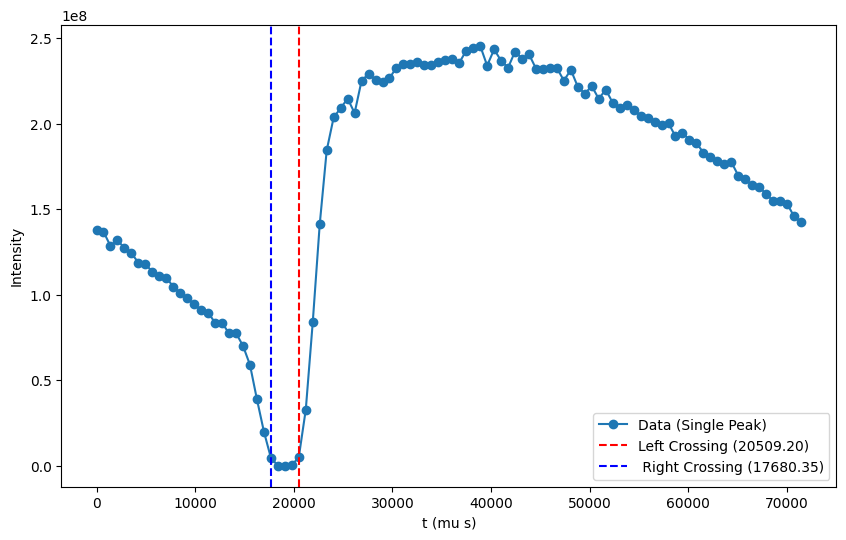

In [6]:

x=example_data.coords['t'].values
y=example_data.values

left_x, right_x, peak_x, width_x=find_threshold_crossing(y, x, threshold_fraction=0.1)
print(f"FWHM : {width_x}")
print(f"Left Crossing : {left_x}")
print(f"Right Crossing : {right_x}")
plt.figure(figsize=(10, 6))
plt.plot(x, y, label='Data (Single Peak)',marker='o')
plt.xlabel('t (mu s)')
plt.ylabel('Intensity')
plt.axvline(left_x, color='red', linestyle='--', label=f'Left Crossing ({left_x:.2f})')
plt.axvline(right_x, color='blue', linestyle='--', label=f' Right Crossing ({right_x:.2f})')
plt.legend()

In [7]:
# Define a fit function. In this simple example the fit parameters are global variables.
def Gaussian(x: np.ndarray) -> np.ndarray:
    """
    Mathematical model for a Gaussian function.
    
    :x: values to calculate the model over. 
    :A: amplitude of the Gaussian.
    :mu: mean (center) of the Gaussian.
    :sigma: standard deviation of the Gaussian.
    :BG: background.
    
    :return: model values.
    """
    return A.value * np.exp(-0.5 * ((x - mu.value) / sigma.value) ** 2)+BG.value


# The easyscience workflow is to create a function, then define the relevant Parameters. The Parameters are collected in a BaseObj, which is then passed to the Fitter along with the fit function.
# To fit the data, we pass x, y and weights to the fitter.

#Create easyscience Parameters with starting values and optional constraints
A=Parameter(name='A', value=2e9, fixed=False,min=0)
mu=Parameter(name='mu', value=30000, fixed=False)
# mu=Parameter(name='mu', value=9000, fixed=False)
sigma=Parameter(name='sigma', value=1500, fixed=False,min=0)
BG=Parameter(name='BG', value=0.1, fixed=False,min=0)

#Create easyscience BaseObj with the Gaussian model and the Parameters
Gaussian_Obj = BaseObj(name='Gaussian_Obj', A=A, mu=mu, sigma=sigma,BG=BG)
f = Fitter(Gaussian_Obj, Gaussian )
# You can do more things here, such as changing the fit method. Let's stick with the default for now.


In [8]:
# Extract x, y and errors to pass to the fitter.
x=example_data.coords['t'].values
y=example_data.values
yerr=np.sqrt(example_data.variances+1e7) # adding a constant to the variance to avoid problems at the tails

# Carry out the fitting,.
res=f.fit(x=x, y=y, weights=1/yerr)
# res=f.fit(x=x, y=y, weights=np.sqrt(y))
A,mu,sigma,BG



(<Parameter 'A': 305515016.2829, bounds=[0.0:inf]>,
 <Parameter 'mu': 30067.4938, bounds=[-inf:inf]>,
 <Parameter 'sigma': 2701.8365, bounds=[0.0:inf]>,
 <Parameter 'BG': 0.0950, bounds=[0.0:inf]>)

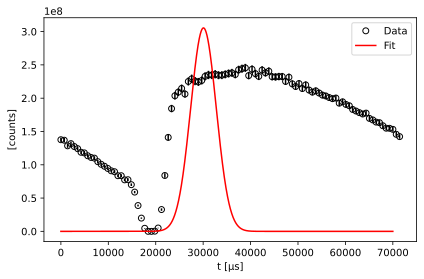

In [9]:


# Calculate the fit values for the x values of the data
xx=np.linspace(0,70000,5000) # Plot the fit on a smoother curve by using more points
fit_values=sc.array(values=Gaussian(xx),dims='t',unit='counts')

# Put the fit into a DataArray for plotting. We need to tell scipp what the units are.
Fit=sc.DataArray(data=fit_values,coords={'t': sc.array(values=xx,dims='t',unit='micro*s')})

data_and_fit=sc.DataGroup({'Data': example_data,
                          'Fit': Fit})

# We use plopp to plot the data and the fit
pp.plot(data_and_fit,
        linestyle=         {'Data': 'none',    'Fit': '-'},
        marker=            {'Data': 'o',       'Fit':'none'},
        markerfacecolor=   {'Data': 'none',    'Fit':'red'},
        color=             {'Data': 'black',   'Fit':'red'})




In [10]:


# # Create a synthetic dataset with a single peak
# np.random.seed(42)  # For reproducibility
# x_single_peak = np.linspace(0, 10, 100)
# data_single_peak = np.exp(-((x_single_peak - 5) ** 2) / 2)  # Gaussian peak centered at x=5

# # Find the FWHM (50% of max) using the specified x values
# fwhm_with_x_single, left_x_single, right_x_single = find_fwhm(data_single_peak, x=x_single_peak, fraction=0.5)

# # Find the FW@10% (10% of max) using the specified x values
# fw10_with_x_single, left_x10_single, right_x10_single = find_fwhm(data_single_peak, x=x_single_peak, fraction=0.1)

# # Plot the single peak dataset with FWHM and FW@10%
# plt.figure(figsize=(10, 6))
# plt.plot(x_single_peak, data_single_peak, label='Data (Single Peak)')
# plt.axvline(left_x_single, color='red', linestyle='--', label=f'FWHM Left Crossing ({left_x_single:.2f})')
# plt.axvline(right_x_single, color='blue', linestyle='--', label=f'FWHM Right Crossing ({right_x_single:.2f})')
# plt.axvline(left_x10_single, color='orange', linestyle='--', label=f'10% Left Crossing ({left_x10_single:.2f})')
# plt.axvline(right_x10_single, color='green', linestyle='--', label=f'10% Right Crossing ({right_x10_single:.2f})')
# plt.title('Single Peak Dataset with FWHM and 10% of Max')
# plt.xlabel('x')
# plt.ylabel('Data')
# plt.legend()
# plt.grid(True)
# plt.show()

# # Test with a smaller non-cyclic dataset
# data_small = np.array([0, 1, 4, 7, 10, 7, 4, 1, 0])  # A single peak without cyclic nature
# x_small = np.linspace(0, 1, len(data_small))  # Example x values (fractional)

# # Find the FWHM (50% of max) for the small non-cyclic dataset
# fwhm_with_x_small, left_x_small_specified, right_x_small_specified = find_fwhm(data_small, x=x_small, fraction=0.5)

# # Find the FW@10% (10% of max) for the small non-cyclic dataset
# fw10_with_x_small, left_x10_small_specified, right_x10_small_specified = find_fwhm(data_small, x=x_small, fraction=0.1)

# # Plot the small non-cyclic dataset with FWHM and FW@10%
# plt.figure(figsize=(10, 6))
# plt.plot(x_small, data_small, label='Data (Small, Non-Cyclic)')
# plt.axvline(left_x_small_specified, color='red', linestyle='--', label=f'FWHM Left Crossing ({left_x_small_specified:.2f})')
# plt.axvline(right_x_small_specified, color='blue', linestyle='--', label=f'FWHM Right Crossing ({right_x_small_specified:.2f})')
# plt.axvline(left_x10_small_specified, color='orange', linestyle='--', label=f'10% Left Crossing ({left_x10_small_specified:.2f})')
# plt.axvline(right_x10_small_specified, color='green', linestyle='--', label=f'10% Right Crossing ({right_x10_small_specified:.2f})')
# plt.title('Small Non-Cyclic Dataset with FWHM and 10% of Max')
# plt.xlabel('x')
# plt.ylabel('Data')
# plt.legend()
# plt.grid(True)
# plt.show()

# # Print the FWHM and FW@10% results
# print(f"FWHM with specified x (single peak dataset): {fwhm_with_x_single}")
# print(f"FW@10% with specified x (single peak dataset): {fw10_with_x_single}")
# print(f"FWHM with specified x (small non-cyclic dataset): {fwhm_with_x_small}")
# print(f"FW@10% with specified x (small non-cyclic dataset): {fw10_with_x_small}")


In [11]:
x=example_data.coords['t'].values
y=example_data.values

fwhm_with_x_single, left_x_single, right_x_single=find_fwhm(y, x, fraction=0.5)
print(f"FWHM : {fwhm_with_x_single}")
print(f" {2.35*sigma.value}")

FWHM : 31289.03085747653
 6349.31578036995


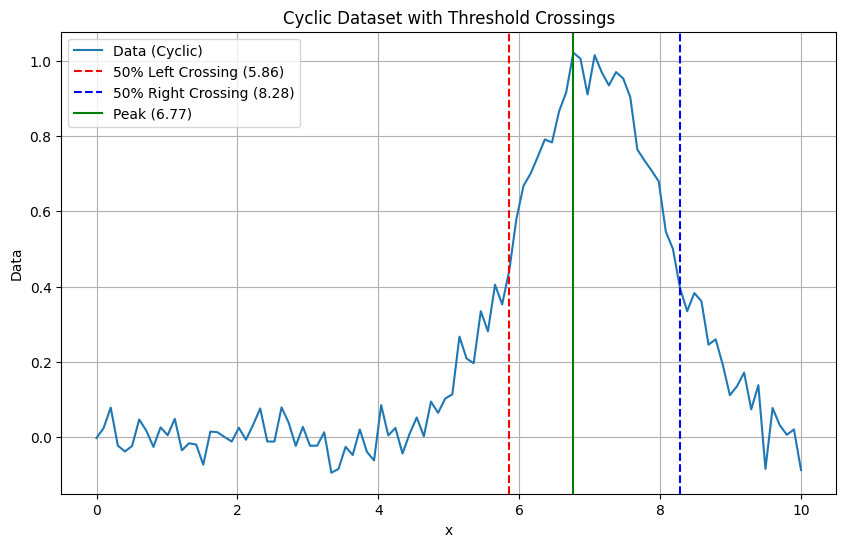

Peak x-value: 6.767676767676767
Left crossing at 50% of peak: 5.858585858585858
Right crossing at 50% of peak: 8.282828282828282


In [12]:
import numpy as np
import matplotlib.pyplot as plt

def find_threshold_crossing(data, x=None, threshold_fraction=0.5):
    """
    Find the x-values where the data crosses a specified threshold of the peak value,
    considering the cyclic nature of the data.

    Parameters:
    - data (numpy array): The data containing the peak.
    - x (numpy array): The x-axis values corresponding to the data points. If None, indices will be used.
    - threshold_fraction (float): The fraction of the peak value to find the crossing at.

    Returns:
    - left_x (float): The x-value of the crossing point to the left of the peak.
    - right_x (float): The x-value of the crossing point to the right of the peak.
    - peak_x (float): The x-value of the peak.
    """

    if x is None:
        x = np.arange(len(data))  # Use indices if x is not provided

    # Ensure x is a numpy array
    x = np.asarray(x)

    # Find the maximum value and its index
    max_value = np.max(data)
    max_index = np.argmax(data)
    peak_x = x[max_index]

    # Calculate the threshold value
    threshold_value = max_value * threshold_fraction

    # Find left crossing
    left_x = None
    for i in range(max_index, max_index - len(data), -1):
        idx = i % len(data)  # Wrap around using modulo
        if data[idx] < threshold_value:
            if idx == 0:
                interp_left = np.interp(threshold_value, [data[-1], data[0]], [x[-1] - x[-1] + x[0], x[0]])
            else:
                interp_left = np.interp(threshold_value, [data[idx-1], data[idx]], [x[idx-1], x[idx]])
            left_x = interp_left
            break

    # Find right crossing
    right_x = None
    for i in range(max_index, max_index + len(data)):
        idx = i % len(data)  # Wrap around using modulo
        if data[idx] < threshold_value:
            if idx == len(data) - 1:
                interp_right = np.interp(threshold_value, [data[idx], data[0]], [x[idx], x[0] + x[-1] - x[0]])
            else:
                interp_right = np.interp(threshold_value, [data[idx], data[idx+1]], [x[idx], x[idx+1]])
            right_x = interp_right
            break

    return left_x, right_x, peak_x

# Example usage with a cyclic dataset
np.random.seed(42)  # For reproducibility
x_cyclic = np.linspace(0, 10, 100)
data_cyclic = np.exp(-((x_cyclic - 5) ** 2) / 2) + 0.05 * np.random.normal(size=x_cyclic.size)  # Slightly noisy Gaussian peak

# Wrap the data by rolling it
data_cyclic = np.roll(data_cyclic, 20)

# Find the crossing points at 50% of the peak value
left_x_cyclic, right_x_cyclic, peak_x_cyclic = find_threshold_crossing(data_cyclic, x=x_cyclic, threshold_fraction=0.5)

# Plot the cyclic dataset with crossings
plt.figure(figsize=(10, 6))
plt.plot(x_cyclic, data_cyclic, label='Data (Cyclic)')
plt.axvline(left_x_cyclic, color='red', linestyle='--', label=f'50% Left Crossing ({left_x_cyclic:.2f})')
plt.axvline(right_x_cyclic, color='blue', linestyle='--', label=f'50% Right Crossing ({right_x_cyclic:.2f})')
plt.axvline(peak_x_cyclic, color='green', linestyle='-', label=f'Peak ({peak_x_cyclic:.2f})')
plt.title('Cyclic Dataset with Threshold Crossings')
plt.xlabel('x')
plt.ylabel('Data')
plt.legend()
plt.grid(True)
plt.show()

# Print the results
print(f"Peak x-value: {peak_x_cyclic}")
print(f"Left crossing at 50% of peak: {left_x_cyclic}")
print(f"Right crossing at 50% of peak: {right_x_cyclic}")
